In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import networkx as nx
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import seaborn as sns
import subprocess
import pandas as pd

from nosh.sim import NoshGraphSimulation
import nosh.utils as uu

In [116]:
output_dir=os.path.join(os.environ['HOME'], 'Documents', 'nosh', 'outputs')
os.makedirs(output_dir, exist_ok=True)

In [117]:
## function to run the simulation for the parameters we care about

def run_network_growth_simulation(ec_alpha_vec, add_delete_maintain_trajectory, num_time_steps=100):
    ###  In this, we don't alter reputation scores for simplicity, we can change this assumption later
    initial_buyers_kwargs = [
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
    ]
    initial_sellers_kwargs = [
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
        {
            'transact_probability': 1.0, 
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        }, 
    ]
    new_buyer_kwargs = {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    new_seller_kwargs = {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    simulation = NoshGraphSimulation(
        initial_buyers_kwargs, 
        initial_sellers_kwargs,
        new_buyer_kwargs,
        new_seller_kwargs,
        seed=1
    )

    # Set the probability vector for adding, deleting, or maintaining the graph in terms of number of nodes

    # Run the simulation
    num_time_steps = 100
    # add_delete_maintain_probs = np.ones((num_time_steps, 3)) * [0.5, 0.0, 0.5]
    weight_alpha_vec = np.ones(num_time_steps) * 1

    reputation_alpha_vec = np.ones(num_time_steps) * 1
    graph_evolution_metrics = simulation.run(
        num_time_steps, 
        add_delete_maintain_trajectory, 
        weight_alpha_vec,
        ec_alpha_vec,
        reputation_alpha_vec,
    )

    return {
        'ec_alpha_vec': ec_alpha_vec,
        'graph_evolution_metrics': graph_evolution_metrics,
        'seller2ec_by_t': uu.eigenvector_centrality_metric_fn(graph_evolution_metrics),
        'seller2totalweight_by_t': uu.total_weight_metric_fn(graph_evolution_metrics),
        'seller2graphvalue_by_t': uu.seller_totalvalue_metric_fn(graph_evolution_metrics),
    }

def run_network_ss_simulation(ec_alpha_vec, add_delete_maintain_trajectory, num_time_steps=100):
    ###  In this, we don't alter reputation scores for simplicity, we can change this assumption later
    # add 30 buyers + sellers and don't change the network
    num_buyers = 30
    num_sellers = 30
    initial_buyers_kwargs = []
    initial_sellers_kwargs = []
    for ii in range(num_buyers):
        initial_buyers_kwargs.append({
            'transact_probability': 0.3,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        })
    for ii in range(num_sellers):
        initial_sellers_kwargs.append({
            'transact_probability': 1.0,
            'unstake_probability': 0.0,
            'reputation_process_kwargs': {
                'mu': 0,
                'sigma': 0,
                'start_value': 1,
            }
        })
    new_buyer_kwargs = {
        'transact_probability': 0.3,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    new_seller_kwargs = {
        'transact_probability': 1.0, 
        'unstake_probability': 0.0,
        'reputation_process_kwargs': {
            'mu': 0,
            'sigma': 0,
            'start_value': 1,
        }
    }
    simulation = NoshGraphSimulation(
        initial_buyers_kwargs, 
        initial_sellers_kwargs,
        new_buyer_kwargs,
        new_seller_kwargs,
        seed=1
    )

    # Run the simulation
    num_time_steps = 100
    weight_alpha_vec = np.ones(num_time_steps) * 1
    reputation_alpha_vec = np.ones(num_time_steps) * 1

    graph_evolution_metrics = simulation.run(
        num_time_steps, 
        add_delete_maintain_trajectory, 
        weight_alpha_vec,
        ec_alpha_vec,
        reputation_alpha_vec,
    )

    return {
        'ec_alpha_vec': ec_alpha_vec,
        'graph_evolution_metrics': graph_evolution_metrics,
        'seller2ec_by_t': uu.eigenvector_centrality_metric_fn(graph_evolution_metrics),
        'seller2totalweight_by_t': uu.total_weight_metric_fn(graph_evolution_metrics),
        'seller2graphvalue_by_t': uu.seller_totalvalue_metric_fn(graph_evolution_metrics),
    }

In [118]:
def exponential_increase_trajectory(a, b, x):
    t = np.linspace(0, 1, x)
    trajectory = a * (b / a) ** t
    return trajectory

def exponential_decrease_trajectory(a, b, x):
    t = np.linspace(0, 1, x)
    trajectory = a * (b / a) ** (1-t)
    return trajectory

In [128]:
# ec_alpha_vec = np.ones(num_time_steps) * 1       # constant alpha
num_time_steps = 100
min_alpha = 0.1
max_alpha = 5.0
trajectory1 = np.ones((num_time_steps, 3)) * [0.5, 0.0, 0.5]

constant_ec_alpha_growth_results = run_network_growth_simulation(
    ec_alpha_vec=np.ones(num_time_steps) * 1, 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
rampup_ec_alpha_growth_results = run_network_growth_simulation(
    ec_alpha_vec=np.linspace(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
rampdown_ec_alpha_growth_results = run_network_growth_simulation(
    ec_alpha_vec=np.linspace(max_alpha, min_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
expup_ec_alpha_growth_results = run_network_growth_simulation(
    ec_alpha_vec=exponential_increase_trajectory(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
expdown_ec_alpha_growth_results = run_network_growth_simulation(
    ec_alpha_vec=exponential_decrease_trajectory(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)

trajectory1 = np.ones((num_time_steps, 3)) * [0.0, 0.0, 1.0]
constant_ec_alpha_ss_results = run_network_ss_simulation(
    ec_alpha_vec=np.ones(num_time_steps) * 1, 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
rampup_ec_alpha_ss_results = run_network_ss_simulation(
    ec_alpha_vec=np.linspace(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
rampdown_ec_alpha_ss_results = run_network_ss_simulation(
    ec_alpha_vec=np.linspace(max_alpha, min_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
expup_ec_alpha_ss_results = run_network_ss_simulation(
    ec_alpha_vec=exponential_increase_trajectory(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)
expdown_ec_alpha_ss_results = run_network_ss_simulation(
    ec_alpha_vec=exponential_decrease_trajectory(min_alpha, max_alpha, num_time_steps), 
    add_delete_maintain_trajectory=trajectory1,
    num_time_steps=num_time_steps
)

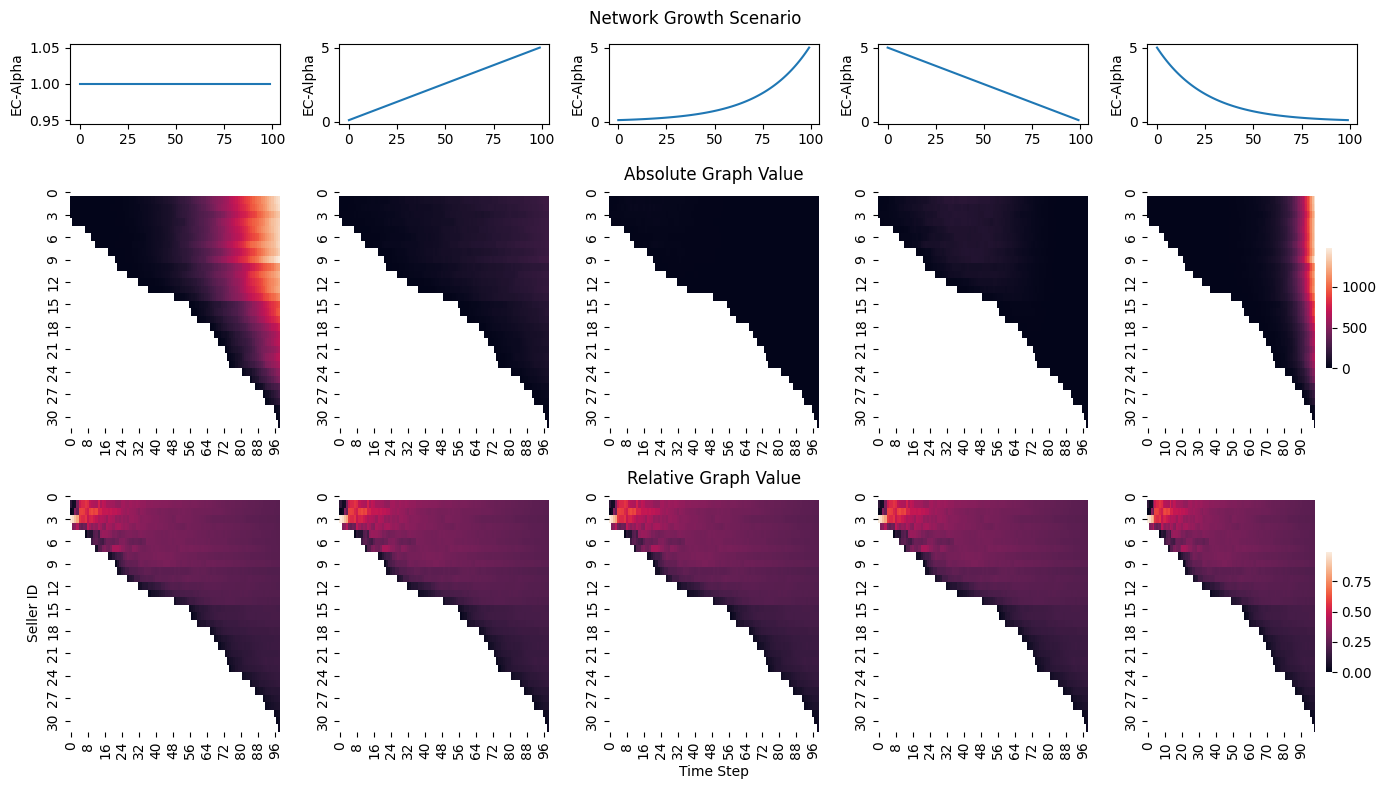

In [130]:
fig = plt.figure(figsize=(14, 8))
nrows = 3
ncols = 5
height_ratios = [1] + [3] * (nrows-1)
width_ratios = [1] * ncols
gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, height_ratios=height_ratios, width_ratios=width_ratios)

col2result_mapping = {
    0: constant_ec_alpha_growth_results,
    1: rampup_ec_alpha_growth_results,
    2: expup_ec_alpha_growth_results,
    3: rampdown_ec_alpha_growth_results,
    4: expdown_ec_alpha_growth_results,
}
vmin_raw = np.inf
vmax_raw = -np.inf
vmin_normalized = np.inf
vmax_normalized = -np.inf

col2normalizedresult_mapping = {}
for col in range(ncols):
    result = col2result_mapping[col]
    graph_value_matrix = result['seller2graphvalue_by_t'][:,1:]

    col_sum = np.nansum(graph_value_matrix, axis=0)  # sum over the columns
    col_sum = np.tile(col_sum, (graph_value_matrix.shape[0], 1)) # broadcast the sum to the same shape as the matrix
    # normalize by the sum of the column to get the proportion of the total value
    graph_value_matrix_normalized = np.divide(graph_value_matrix, col_sum)

    vmin_raw = min(vmin_raw, np.nanmin(graph_value_matrix))
    vmax_raw = max(vmax_raw, np.nanmax(graph_value_matrix))
    vmin_normalized = min(vmin_normalized, np.nanmin(graph_value_matrix_normalized))
    vmax_normalized = max(vmax_normalized, np.nanmax(graph_value_matrix_normalized))

for col in range(ncols):
    # get the graph value for each seller
    graph_value_matrix = result['seller2graphvalue_by_t'][:,1:]

    result = col2result_mapping[col]
    axx = fig.add_subplot(gs[0, col])
    axx.plot(result['ec_alpha_vec'])
    axx.set_ylabel('EC-Alpha')

    axx = fig.add_subplot(gs[1, col])
    cbar = True if col == (ncols-1) else False
    sns.heatmap(graph_value_matrix, ax=axx, vmin=vmin_raw, vmax=vmax_raw, cbar_kws={"shrink": 0.5}, cbar=cbar)
    if col == 2: axx.set_title('Absolute Graph Value')

    
    axx = fig.add_subplot(gs[2, col])
    sns.heatmap(np.sqrt(graph_value_matrix_normalized), ax=axx, vmin=vmin_normalized, vmax=vmax_normalized, cbar_kws={"shrink": 0.5}, cbar=cbar)
    if col==2: axx.set_title('Relative Graph Value')

    if col == 0:
        axx.set_ylabel('Seller ID')

    if col == 2:
        axx.set_xlabel('Time Step')

plt.suptitle('Network Growth Scenario')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ec_alpha_growth.png'))

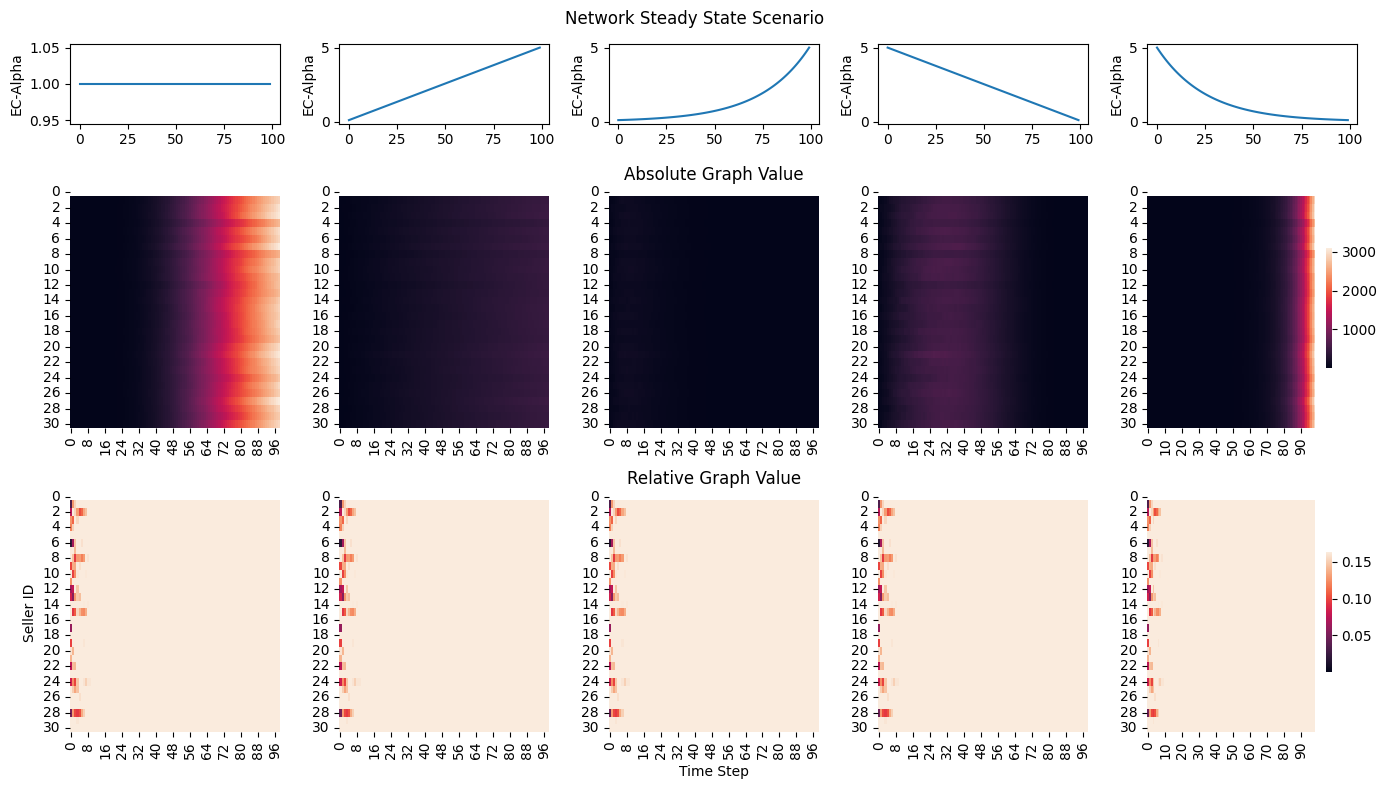

In [133]:
fig = plt.figure(figsize=(14, 8))
nrows = 3
ncols = 5
height_ratios = [1] + [3] * (nrows-1)
width_ratios = [1] * ncols
gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, height_ratios=height_ratios, width_ratios=width_ratios)

col2result_mapping = {
    0: constant_ec_alpha_ss_results,
    1: rampup_ec_alpha_ss_results,    
    2: expup_ec_alpha_ss_results,
    3: rampdown_ec_alpha_ss_results,
    4: expdown_ec_alpha_ss_results,
}

vmin_raw = np.inf
vmax_raw = -np.inf
vmin_normalized = np.inf
vmax_normalized = -np.inf

col2normalizedresult_mapping = {}
for col in range(ncols):
    result = col2result_mapping[col]
    graph_value_matrix = result['seller2graphvalue_by_t'][:,1:]

    col_sum = np.nansum(graph_value_matrix, axis=0)  # sum over the columns
    col_sum = np.tile(col_sum, (graph_value_matrix.shape[0], 1)) # broadcast the sum to the same shape as the matrix
    # normalize by the sum of the column to get the proportion of the total value
    graph_value_matrix_normalized = np.divide(graph_value_matrix, col_sum)

    vmin_raw = min(vmin_raw, np.nanmin(graph_value_matrix))
    vmax_raw = max(vmax_raw, np.nanmax(graph_value_matrix))
    vmin_normalized = min(vmin_normalized, np.nanmin(graph_value_matrix_normalized))
    vmax_normalized = max(vmax_normalized, np.nanmax(graph_value_matrix_normalized))

for col in range(ncols):
    # get the graph value for each seller
    graph_value_matrix = result['seller2graphvalue_by_t'][:,1:]

    result = col2result_mapping[col]
    axx = fig.add_subplot(gs[0, col])
    axx.plot(result['ec_alpha_vec'])
    axx.set_ylabel('EC-Alpha')

    axx = fig.add_subplot(gs[1, col])
    cbar = True if col == (ncols-1) else False
    sns.heatmap(graph_value_matrix, ax=axx, vmin=vmin_raw, vmax=vmax_raw, cbar_kws={"shrink": 0.5}, cbar=cbar)
    if col == 2: axx.set_title('Absolute Graph Value')

    
    axx = fig.add_subplot(gs[2, col])
    sns.heatmap(np.sqrt(graph_value_matrix_normalized), ax=axx, vmin=vmin_normalized, vmax=vmax_normalized, cbar_kws={"shrink": 0.5}, cbar=cbar)
    if col==2: axx.set_title('Relative Graph Value')

    if col == 0:
        axx.set_ylabel('Seller ID')

    if col == 2:
        axx.set_xlabel('Time Step')

plt.suptitle('Network Steady State Scenario')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ec_alpha_steadystate.png'))